In [ ]:
!pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/drive/MyDrive/data_VTAC/players_detailed_all_fixtures_fixed.csv"
df = pd.read_csv(file_path)

# Drop unnecessary columns
cols_to_drop = [
    'player_photo', 'offsides', 'goals_conceded', 'goals_saves',
    'dribbles_past', 'penalty_won', 'penalty_committed',
    'penalty_saved'
]
df.drop(columns=cols_to_drop, inplace=True)

# Fill missing values
cols_fill_zero = [
    'games_minutes', 'games_rating', 'shots_total', 'shots_on',
    'goals_total', 'goals_assists', 'passes_total', 'passes_key',
    'passes_accuracy', 'tackles_total', 'tackles_blocks',
    'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'fouls_drawn',
    'fouls_committed'
]
df[cols_fill_zero] = df[cols_fill_zero].fillna(0)
df = df.dropna(subset=['games_number'])

# Convert rating to numeric
df['games_rating'] = pd.to_numeric(df['games_rating'], errors='coerce')

# Handle percentage format
df['passes_accuracy'] = df['passes_accuracy'].astype(str).str.replace('%', '').astype(float) / 100

# Feature engineering
df['minutes'] = df['games_minutes'].replace(0, 1)
df['passes_per_min'] = df['passes_total'] / df['minutes']
df['duels_per_min'] = df['duels_total'] / df['minutes']
df['dribbles_per_min'] = df['dribbles_attempts'] / df['minutes']
df['fouls_per_min'] = df['fouls_committed'] / df['minutes']
df['dribbles_success_rate'] = df['dribbles_success'] / (df['dribbles_attempts'] + 1e-5)
df['duels_win_rate'] = df['duels_won'] / (df['duels_total'] + 1e-5)
df['contribution_rate'] = (df['goals_total'] + df['goals_assists']) / df['minutes']
df['shot_accuracy'] = df['shots_on'] / (df['shots_total'] + 1e-5)
df['defensive_actions_per_min'] = (df['tackles_total'] + df['tackles_blocks'] + df['tackles_interceptions']) / df['minutes']
df['duels_balance'] = df['duels_total'] - df['duels_won']
df['pass_influence'] = df['passes_key'] / (df['passes_total'] + 1e-5)
df['dribble_pressure'] = df['dribbles_success'] / (df['duels_total'] + 1e-5)
df['discipline_score'] = (df['cards_yellow'] + 2 * df['cards_red']) / df['minutes']

# Encode position
if 'games_position' in df.columns:
    df['position'] = LabelEncoder().fit_transform(df['games_position'])

# Sort and compute rolling features
df = df.sort_values(by=['player_id', 'fixture_id'])
rolling_features = [
    'games_minutes', 'shots_total', 'shots_on', 'goals_total', 'goals_assists',
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'fouls_drawn', 'fouls_committed',
    'cards_yellow', 'cards_red'
]
for col in rolling_features:
    df[f'{col}_avg5'] = df.groupby('player_id')[col].shift(1).rolling(window=5, min_periods=1).mean()
df = df.dropna(subset=[f'{col}_avg5' for col in rolling_features])

# Drop ratios and trends
df['passes_drop_ratio'] = df['passes_total'] / (df['passes_total_avg5'] + 1e-5)
df['duels_drop_ratio'] = df['duels_total'] / (df['duels_total_avg5'] + 1e-5)
df['accuracy_drop_ratio'] = df['passes_accuracy'] / (df['passes_accuracy_avg5'] + 1e-5)
df['passes_trend'] = df.groupby('player_id')['passes_total'].transform(lambda x: x.rolling(3, min_periods=1).apply(lambda s: s.iloc[-1] - s.iloc[0]))
df['duels_trend'] = df.groupby('player_id')['duels_total'].transform(lambda x: x.rolling(3, min_periods=1).apply(lambda s: s.iloc[-1] - s.iloc[0]))
df['accuracy_trend'] = df.groupby('player_id')['passes_accuracy'].transform(lambda x: x.rolling(3, min_periods=1).apply(lambda s: s.iloc[-1] - s.iloc[0]))

# Fatigue score
df['fatigue_score'] = (
    (df['passes_drop_ratio'] < 0.6).astype(int) +
    (df['duels_drop_ratio'] < 0.6).astype(int) +
    (df['accuracy_drop_ratio'] < 0.8).astype(int)
)

# Group comparison
group_avg = df.groupby('position')[['passes_per_min', 'duels_per_min', 'passes_accuracy']].transform('mean')
df['passes_vs_group'] = df['passes_per_min'] / (group_avg['passes_per_min'] + 1e-5)
df['duels_vs_group'] = df['duels_per_min'] / (group_avg['duels_per_min'] + 1e-5)
df['accuracy_vs_group'] = df['passes_accuracy'] / (group_avg['passes_accuracy'] + 1e-5)

df['group_fatigue_score'] = (
    (df['passes_vs_group'] < 0.6).astype(int) +
    (df['duels_vs_group'] < 0.6).astype(int) +
    (df['accuracy_vs_group'] < 0.8).astype(int)
)
df['is_fatigued'] = ((df['fatigue_score'] + df['group_fatigue_score']) >= 3).astype(int)


cols_to_remove = [
    'minutes',                 # مكرر مع games_minutes
    'fatigue_score',           # فيه تسريب واضح لأنه يُستخدم لحساب is_fatigued
    'passes_accuracy_avg5',    # مرتبط جدًا مع passes_accuracy
    'accuracy_vs_group',       # مرتبط جدًا مع passes_accuracy
    'duels_total_avg5',        # مكرر مع duels_won_avg5
    'duels_per_min',           # مكرر تقريبًا مع duels_vs_group
    'passes_per_min',          # مكرر مع passes_vs_group
    'dribbles_attempts_avg5',  # مكرر مع dribbles_success_avg5
    'dribbles_attempts',       # مكرر مع dribbles_success
]

# نحذف الأعمدة إن وجدت
df.drop(columns=[col for col in cols_to_remove if col in df.columns], inplace=True)


# Features for modeling
features = [col for col in df.columns if col.endswith('_avg5')]
extra_features = [
    'passes_drop_ratio', 'duels_drop_ratio', 'accuracy_drop_ratio',
    'passes_trend', 'duels_trend', 'accuracy_trend',
    'passes_accuracy'  # فقط اللي بقى
]


features += [col for col in extra_features if col in df.columns]
if 'position' in df.columns:
    features.append('position')


<ipython-input-8-644af1d5f936>:11: DtypeWarning: Columns (12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
<ipython-input-8-644af1d5f936>:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['passes_drop_ratio'] = df['passes_total'] / (df['passes_total_avg5'] + 1e-5)
<ipython-input-8-644af1d5f936>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['duels_drop_ratio'] = df['duels_total'] / (df['duels_total_avg5'] + 1e-5)
<ipython-input-8-644af1d

In [ ]:
# تحديد الداتا
df_model = df[features + ['is_fatigued']].copy()

# تقسيم
train_df, test_df = train_test_split(
    df_model,
    test_size=0.2,
    random_state=42,
    stratify=df_model['is_fatigued']
)

# تدريب AutoGluon
predictor = TabularPredictor(label='is_fatigued').fit(train_df, time_limit=3600)


No path specified. Models will be saved in: "AutogluonModels/ag-20250417_213922"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Sun Mar 30 16:01:29 UTC 2025
CPU Count:          2
Memory Avail:       7.52 GB / 12.67 GB (59.3%)
Disk Space Avail:   66.31 GB / 112.64 GB (58.9%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions a

[1000]	valid_set's binary_error: 0.0289361


	0.9716	 = Validation score   (accuracy)
	221.59s	 = Training   runtime
	1.43s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 3252.22s of the 3252.21s of remaining time.
	0.9716	 = Validation score   (accuracy)
	85.46s	 = Training   runtime
	0.32s	 = Validation runtime
Fitting model: RandomForestGini ... Training model for up to 3166.37s of the 3166.36s of remaining time.
	0.9684	 = Validation score   (accuracy)
	557.85s	 = Training   runtime
	0.33s	 = Validation runtime
Fitting model: RandomForestEntr ... Training model for up to 2604.04s of the 2604.03s of remaining time.
	0.969	 = Validation score   (accuracy)
	609.18s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 1990.76s of the 1990.75s of remaining time.
	0.9722	 = Validation score   (accuracy)
	611.6s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesGini ... Training model for up to 1379.13s of the 1379.12s of remaini

              precision    recall  f1-score   support

           0       0.97      0.98      0.98    157431
           1       0.98      0.95      0.96     99163

    accuracy                           0.97    256594
   macro avg       0.97      0.97      0.97    256594
weighted avg       0.97      0.97      0.97    256594



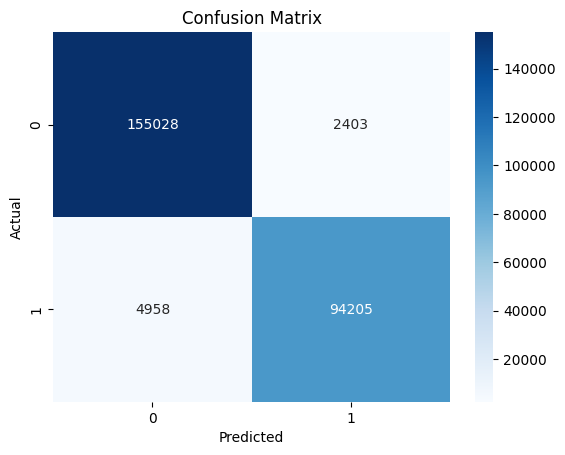

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_test = test_df['is_fatigued']
X_test = test_df.drop(columns=['is_fatigued'])

y_pred = predictor.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
performance = predictor.evaluate(test_df)
performance

{'accuracy': 0.9713126573497431,
 'balanced_accuracy': 0.9673688413963245,
 'mcc': 0.9394251242559053,
 'roc_auc': 0.9970089911145767,
 'f1': 0.962399946876708,
 'precision': 0.9751262835375952,
 'recall': 0.9500015126609723}

In [ ]:
df_live = pd.read_csv("/content/players_live_fixture_1208311.csv")  # أو DataFrame جاهز فيه البيانات اللحظية لكل لاعب


In [ ]:
# التعامل مع القيم المفقودة
cols_fill_zero = [
    'games_minutes', 'shots_total', 'shots_on', 'goals_total',
    'goals_assists', 'passes_total', 'passes_key', 'passes_accuracy',
    'tackles_total', 'tackles_blocks', 'tackles_interceptions',
    'duels_total', 'duels_won', 'dribbles_success', 'fouls_drawn',
    'fouls_committed', 'cards_yellow', 'cards_red'
]
df_live[cols_fill_zero] = df_live[cols_fill_zero].fillna(0)
df_live['passes_accuracy'] = df_live['passes_accuracy'].astype(str).str.replace('%', '').astype(float) / 100
df_live['minutes'] = df_live['games_minutes'].replace(0, 1)

# اشتقاق الفيتشرز اللحظية
df_live['passes_per_min'] = df_live['passes_total'] / df_live['minutes']
df_live['duels_per_min'] = df_live['duels_total'] / df_live['minutes']
df_live['dribbles_per_min'] = df_live['dribbles_success'] / df_live['minutes']
df_live['fouls_per_min'] = df_live['fouls_committed'] / df_live['minutes']
df_live['dribbles_success_rate'] = df_live['dribbles_success'] / (df_live['dribbles_success'] + 1e-5)
df_live['duels_win_rate'] = df_live['duels_won'] / (df_live['duels_total'] + 1e-5)
df_live['contribution_rate'] = (df_live['goals_total'] + df_live['goals_assists']) / df_live['minutes']
df_live['shot_accuracy'] = df_live['shots_on'] / (df_live['shots_total'] + 1e-5)
df_live['defensive_actions_per_min'] = (
    df_live['tackles_total'] + df_live['tackles_blocks'] + df_live['tackles_interceptions']
) / df_live['minutes']
df_live['duels_balance'] = df_live['duels_total'] - df_live['duels_won']
df_live['pass_influence'] = df_live['passes_key'] / (df_live['passes_total'] + 1e-5)
df_live['dribble_pressure'] = df_live['dribbles_success'] / (df_live['duels_total'] + 1e-5)
df_live['discipline_score'] = (df_live['cards_yellow'] + 2 * df_live['cards_red']) / df_live['minutes']

# ترميز المركز لو موجود
if 'games_position' in df_live.columns:
    df_live['position'] = LabelEncoder().fit_transform(df_live['games_position'])


In [ ]:
df_all = pd.concat([df, df_live], ignore_index=True)
df_all = df_all.sort_values(by=['player_id', 'fixture_id'])


In [ ]:
rolling_features = ['games_minutes', 'shots_total', 'shots_on', 'goals_total', 'goals_assists',
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_success', 'fouls_drawn', 'fouls_committed',
    'cards_yellow', 'cards_red'
]

for col in rolling_features:
    df_all[f'{col}_avg5'] = (
        df_all.groupby('player_id')[col]
        .shift(1)  # بدون استخدام المباراة الحالية
        .rolling(window=5, min_periods=1)
        .mean()
        .reset_index(0, drop=True)
    )


In [ ]:
df_live_with_avg = df_all[df_all['fixture_id'].isin(df_live['fixture_id'])]


In [ ]:
inference_data = df_live_with_avg[features].copy()


In [ ]:
from autogluon.tabular import TabularPredictor

# تجهيز البيانات للتنبؤ
inference_data = df_live_with_avg[features].copy()

# تحميل النموذج
predictor = TabularPredictor.load("/content/AutogluonModels/ag-20250417_213922")

# التنبؤ
preds = predictor.predict(inference_data)
probas = predictor.predict_proba(inference_data)[1]  # احتمال التعب

df_live_with_avg = df_live_with_avg.copy()

# إضافة التنبؤات
df_live_with_avg['is_fatigued_pred'] = preds
df_live_with_avg['fatigue_probability'] = probas

# تصفية المتعبين فقط وترتيبهم حسب الأعلى احتمال
top_fatigued = df_live_with_avg[df_live_with_avg['is_fatigued_pred'] == 1] \
    .sort_values(by='fatigue_probability', ascending=False)

# الأعمدة التي نريد عرضها
columns_to_show = ['player_name', 'position', 'team_name', 'timestamp', 'fatigue_probability']
top_fatigued[columns_to_show].head(10)





,player_name,position,team_name,timestamp,fatigue_probability
1283226,Callum Wilson,1,Newcastle,2025-04-16T19:05:04.075673,0.992058
1283747,Callum Wilson,1,Newcastle,2025-04-16T20:10:11.743493,0.992057
1283502,Emil Krafth,0,Newcastle,2025-04-16T19:40:09.161741,0.992057
1283200,Matt Turner,2,Crystal Palace,2025-04-16T19:00:03.706477,0.992057
1283184,Sean Longstaff,3,Newcastle,2025-04-16T19:00:03.706357,0.992057
1283503,Joe Willock,3,Newcastle,2025-04-16T19:40:09.161753,0.992057
1283625,Lewis Miley,3,Newcastle,2025-04-16T19:55:10.451439,0.992057
1283504,Sean Longstaff,3,Newcastle,2025-04-16T19:40:09.161766,0.992057
1283202,Ben Chilwell,0,Crystal Palace,2025-04-16T19:00:03.706492,0.992057
1283201,Nathaniel Clyne,0,Crystal Palace,2025-04-16T19:00:03.706484,0.992057
